# Notebook 4: Spatial Statistics with Squidpy

**Tutor:** Anthony Christidis  
**Time:** 45 minutes

Welcome to spatial statistics analysis! In this notebook, we'll use squidpy to ask sophisticated questions about spatial organization in Visium data.

Spatial statistics go beyond simple visualization - they quantify patterns, test hypotheses, and reveal biological insights about tissue organization.

## Goals:
- Identify spatially variable genes using Moran's I spatial autocorrelation
- Analyze neighborhood enrichment to understand tissue organization
- Investigate ligand-receptor interactions between tissue regions
- Perform spatial co-occurrence analysis

In [1]:
# for cleaner output

import warnings
warnings.filterwarnings("ignore")

In [2]:
import spatialdata as sd
import spatialdata_plot as sdp
import scanpy as sc
import squidpy as sq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.lines import Line2D
from pathlib import Path

# Define the path to our data directory
# Note: This path is relative to the repository's root directory
_DATA_DIR_PATH = Path("../data/")
_VISIUM_PATH = _DATA_DIR_PATH / "visium_glioblastoma_subset.zarr"
_XENIUM_PATH = _DATA_DIR_PATH / "xenium_lung_cancer_subset.zarr"

# Print versions for reproducibility
for p in [sd, sdp, sc, sq]:
    print(f"{p.__name__}: {p.__version__}")

spatialdata: 0.5.0
spatialdata_plot: 0.2.13
scanpy: 1.11.5
squidpy: 1.6.5


## Loading Visium Glioblastoma Data

In [3]:
sdata_visium = sd.read_zarr("../data/visium_glioblastoma_subset.zarr")

# adata_visium = sdata_visium.tables["table"].copy()

print(f"Loaded {sdata_visium.tables['table'].n_obs} spots with {sdata_visium.tables['table'].n_vars} genes")

Loaded 5756 spots with 18085 genes


## Part 1: Data Preparation and Basic Processing

Before diving into spatial statistics, we need to preprocess our data and run basic clustering to identify tissue regions.

In [4]:
# Calculate QC metrics
sc.pp.calculate_qc_metrics(sdata_visium.tables["table"], percent_top=(20, 50), inplace=True)

# Filter low-quality spots and rare genes
print(f"Starting with: {sdata_visium.tables['table'].n_obs} spots")
sc.pp.filter_cells(sdata_visium.tables["table"], min_counts=500)
sc.pp.filter_genes(sdata_visium.tables["table"], min_cells=10)
print(f"After filtering: {sdata_visium.tables['table'].n_obs} spots")

# Standard preprocessing pipeline
sc.pp.normalize_total(sdata_visium.tables["table"], inplace=True)
sc.pp.log1p(sdata_visium.tables["table"])
sc.pp.highly_variable_genes(sdata_visium.tables["table"])
sc.pp.pca(sdata_visium.tables["table"], use_highly_variable=True)
sc.pp.neighbors(sdata_visium.tables["table"])
sc.tl.leiden(sdata_visium.tables["table"], key_added="leiden_clusters")
sc.tl.umap(sdata_visium.tables["table"])

n_clusters = len(sdata_visium.tables["table"].obs['leiden_clusters'].unique())
print(f"Identified {n_clusters} tissue regions/clusters")

Starting with: 5756 spots
After filtering: 5734 spots
Identified 17 tissue regions/clusters


INFO     Converting 5734 shapes to visium_hex.                                                                     


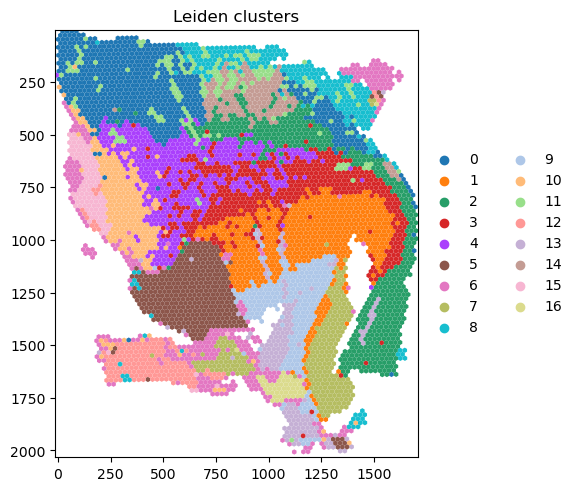

In [5]:
(
    sdata_visium
    .pl.render_shapes(color="leiden_clusters", shape="visium_hex")
    .pl.show("downscaled_hires", title="Leiden clusters")
)

In [6]:
# Visualize the identified clusters
# fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# UMAP view
# sc.pl.umap(adata_visium, color="leiden_clusters", ax=axes[0], show=False, frameon=False)
# axes[0].set_title('Tissue Regions (UMAP)')

# Spatial view using our reliable matplotlib method
# coords = adata_visium.obsm['spatial']
# x_coords = coords[:, 0]
# y_coords = coords[:, 1]
# cluster_codes = adata_visium.obs['leiden_clusters'].astype('category').cat.codes

# scatter = axes[1].scatter(x_coords, y_coords, c=cluster_codes, 
#                          cmap='tab10', s=25, alpha=0.8)
# axes[1].set_title('Tissue Regions (Spatial View)')
# axes[1].set_aspect('equal')

# Add legend
# unique_clusters = sorted(adata_visium.obs['leiden_clusters'].unique())
# colors = plt.cm.tab10(np.linspace(0, 1, len(unique_clusters)))
# legend_elements = [Line2D([0], [0], marker='o', color='w', 
#                          markerfacecolor=colors[i], markersize=8, 
#                          label=f'Region {cluster}') 
#                   for i, cluster in enumerate(unique_clusters)]
# axes[1].legend(handles=legend_elements, bbox_to_anchor=(1.05, 1), loc='upper left')

# plt.tight_layout()
# plt.show()

## Part 2: Spatial Neighbors Graph

The foundation of spatial analysis is building a graph that connects spatially adjacent spots. This graph structure allows us to quantify spatial relationships and define "neighborhoods" in tissue space. Each spot is connected to its immediate spatial neighbors, creating a network that preserves the tissue's geometric structure.

In [7]:
# Build spatial neighborhood graph
# This connects each spot to its spatial neighbors
sq.gr.spatial_neighbors(sdata_visium.tables["table"])

print(f"Built spatial graph with {sdata_visium.tables['table'].obsp['spatial_connectivities'].nnz} connections")
print(f"Average neighbors per spot: {sdata_visium.tables['table'].obsp['spatial_connectivities'].nnz / sdata_visium.tables['table'].n_obs:.1f}")

Built spatial graph with 33192 connections
Average neighbors per spot: 5.8


## Part 3: Spatially Variable Genes - Moran's I Analysis

**Biological Question:** Which genes show non-random spatial expression patterns?

**Moran's I** is a spatial autocorrelation statistic that measures how similar neighboring spots are in their gene expression. It ranges from -1 to +1:
- **High positive values**: Genes with spatially coherent expression (neighboring spots have similar expression)
- **Values near 0**: Random spatial distribution
- **Negative values**: Spatially anti-correlated expression (checkerboard-like patterns)

Genes with high Moran's I often mark anatomical structures, functional domains, or pathological regions.

In [8]:
# Calculate Moran's I for spatially variable gene detection
# We'll test highly variable genes for computational efficiency
hvg_genes = sdata_visium.tables["table"].var_names[sdata_visium.tables["table"].var['highly_variable']]

sq.gr.spatial_autocorr(
    sdata_visium.tables["table"],
    mode="moran",
    genes=hvg_genes,
    n_perms=100,  # Number of permutations for statistical testing
    n_jobs=4      # Parallel processing
)

# Display the top spatially variable genes
moran_results = sdata_visium.tables["table"].uns["moranI"].sort_values(by="I", ascending=False)
print("\nTop 10 spatially variable genes:")
print(moran_results.head(10)[['I', 'pval_sim']].round(4))

print("\nBottom 10 spatially variable genes (most random):")
print(moran_results.tail(10)[['I', 'pval_sim']].round(4))

  0%|          | 0/100 [00:00<?, ?/s]

/Users/tim.treis/Documents/GitHub/Spatial-Workshop/.pixi/envs/default/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/tim.treis/Documents/GitHub/Spatial-Workshop/.pixi/envs/default/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/tim.treis/Documents/GitHub/Spatial-Workshop/.pixi/envs/default/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is


Top 10 spatially variable genes:
               I  pval_sim
HBB       0.8140    0.0099
COL1A1    0.7089    0.0099
CREG2     0.6991    0.0099
HSPA1B    0.6969    0.0099
SYN2      0.6968    0.0099
PMP2      0.6938    0.0099
HPCA      0.6930    0.0099
VSNL1     0.6906    0.0099
ATRNL1    0.6814    0.0099
CRISPLD1  0.6793    0.0099

Bottom 10 spatially variable genes (most random):
               I  pval_sim
TRIM61   -0.0074    0.0891
RNF32    -0.0076    0.0693
PRR19    -0.0076    0.0198
GJC3     -0.0078    0.0297
FAM81B   -0.0081    0.0198
CFP      -0.0085    0.0990
CCNI2    -0.0091    0.0099
CTRL     -0.0093    0.0495
B3GNT7   -0.0093    0.0198
SERPINF2 -0.0094    0.0495


INFO     Converting 5734 shapes to visium_hex.                                                                     
INFO     Converting 5734 shapes to visium_hex.                                                                     
INFO     Converting 5734 shapes to visium_hex.                                                                     
INFO     Converting 5734 shapes to visium_hex.                                                                     
INFO     Converting 5734 shapes to visium_hex.                                                                     
INFO     Converting 5734 shapes to visium_hex.                                                                     
High Moran's I (top row) = genes with spatially coherent expression
Low Moran's I (bottom row) = genes with spatially random expression


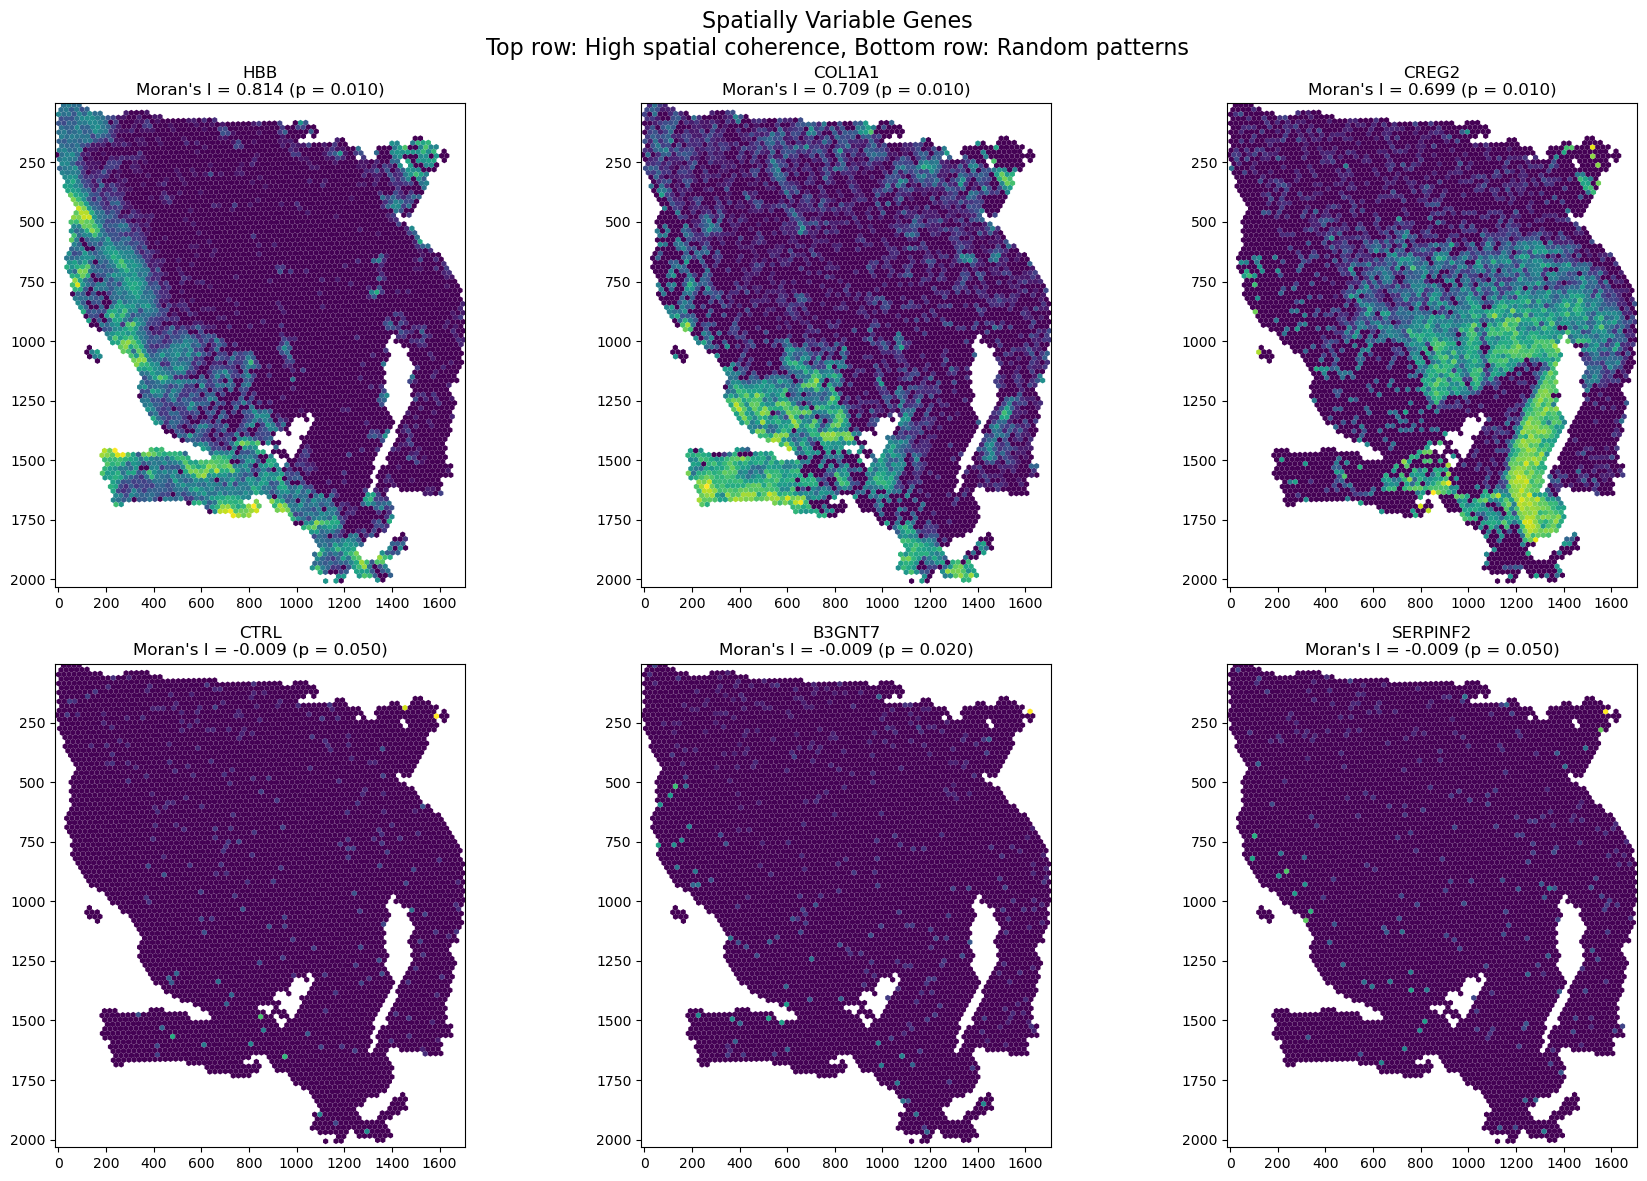

In [9]:
# Visualize top spatially variable genes
top_genes = moran_results.head(3).index.tolist()
bottom_genes = moran_results.tail(3).index.tolist()
genes_to_plot = top_genes + bottom_genes

fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.flatten()

# coords = adata_visium.obsm['spatial']
# x_coords = coords[:, 0]
# y_coords = coords[:, 1]

for idx, gene in enumerate(genes_to_plot):
    moran_score = moran_results.loc[gene, 'I']
    p_value = moran_results.loc[gene, 'pval_sim']
    
    # Get gene expression values
    # gene_expr = adata_visium[:, gene].X.toarray().flatten() if hasattr(adata_visium.X, 'toarray') else adata_visium[:, gene].X.flatten()

    (
        sdata_visium
        .pl.render_shapes(
            color=gene,
            shape="visium_hex",
        )
        .pl.show(
            "downscaled_hires",
            title=f'{gene}\nMoran\'s I = {moran_score:.3f} (p = {p_value:.3f})',
            ax=axs[idx],
            colorbar=False,
        )
    )
    # scatter = axs[idx].scatter(x_coords, y_coords, c=gene_expr, 
    #                           cmap='viridis', s=20, alpha=0.8)
    # axs[idx].set_title()
    # axs[idx].set_aspect('equal')
    # plt.colorbar(scatter, ax=axs[idx])

fig.suptitle('Spatially Variable Genes\nTop row: High spatial coherence, Bottom row: Random patterns', fontsize=16)
fig.tight_layout()
fig.show()

print("High Moran's I (top row) = genes with spatially coherent expression")
print("Low Moran's I (bottom row) = genes with spatially random expression")

## Part 4: Neighborhood Enrichment Analysis

**Biological Question:** Which tissue regions tend to be spatially adjacent to each other?

**Neighborhood enrichment** reveals the "social network" of tissue regions by comparing observed spatial adjacencies to what we'd expect by random chance. This analysis uses permutation testing to calculate Z-scores that indicate:
- **Positive enrichment**: Regions are neighbors more often than expected (spatial attraction)
- **Negative enrichment**: Regions avoid each other spatially (spatial segregation)
- **No enrichment**: Random spatial association

This can reveal important biological patterns like tumor-stroma boundaries or immune cell exclusion zones.

  0%|          | 0/1000 [00:00<?, ?/s]

/Users/tim.treis/Documents/GitHub/Spatial-Workshop/.pixi/envs/default/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/tim.treis/Documents/GitHub/Spatial-Workshop/.pixi/envs/default/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/Users/tim.treis/Documents/GitHub/Spatial-Workshop/.pixi/envs/default/lib/python3.11/site-packages/squidpy/gr/_utils.py:23: FutureWarning: `__version__` is d

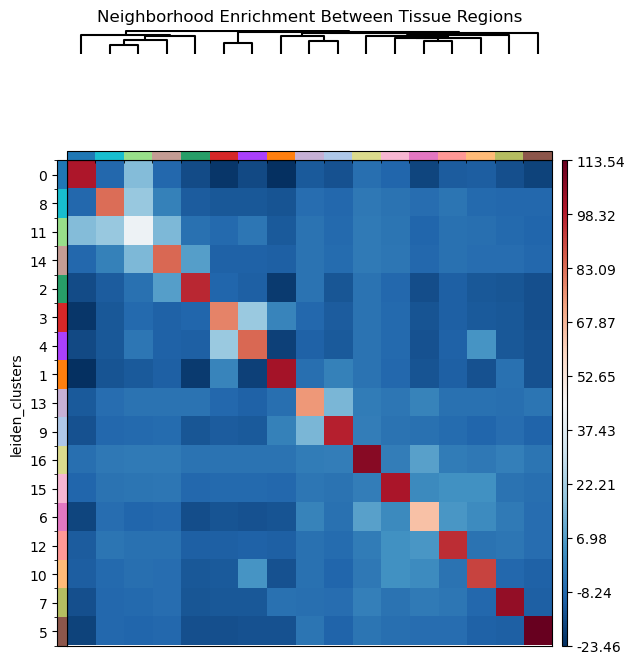


Interpretation:
• Red (positive Z-score): Regions are neighbors more often than expected by chance
• Blue (negative Z-score): Regions avoid each other spatially
• White (Z-score ≈ 0): Random spatial association


In [10]:
# Calculate neighborhood enrichment between tissue regions
sq.gr.nhood_enrichment(sdata_visium.tables["table"], cluster_key="leiden_clusters")

# Visualize the enrichment matrix
fig, ax = plt.subplots(figsize=(10, 8))
sq.pl.nhood_enrichment(
    sdata_visium.tables["table"], 
    cluster_key="leiden_clusters",
    method="ward",  # Hierarchical clustering to group similar patterns
    cmap="RdBu_r",  # Red-blue colormap (red=enriched, blue=depleted)
    ax=ax
)
plt.title('Neighborhood Enrichment Between Tissue Regions')
plt.show()

print("\nInterpretation:")
print("• Red (positive Z-score): Regions are neighbors more often than expected by chance")
print("• Blue (negative Z-score): Regions avoid each other spatially") 
print("• White (Z-score ≈ 0): Random spatial association")

## Part 5: Co-occurrence Analysis

**Biological Question:** How does the spatial association between regions change with distance?

**Co-occurrence analysis** extends beyond immediate neighbors to examine spatial relationships across multiple distance scales. It calculates the conditional probability of finding specific tissue regions together at increasing distances, revealing:
- **Short-range interactions**: Direct cell-cell contacts
- **Medium-range patterns**: Tissue architecture and zoning
- **Long-range organization**: Organ-level structure

This helps distinguish between direct cellular interactions and broader architectural organization.

  0%|          | 0/1 [00:00<?, ?/s]

/Users/tim.treis/Documents/GitHub/Spatial-Workshop/.pixi/envs/default/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/tim.treis/Documents/GitHub/Spatial-Workshop/.pixi/envs/default/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/Users/tim.treis/Documents/GitHub/Spatial-Workshop/.pixi/envs/default/lib/python3.11/site-packages/squidpy/gr/_utils.py:23: FutureWarning: `__version__` is d

ERROR: Unable to fetch palette, reason: 'leiden_clusters_colors'. Using `None`.


<Figure size 1200x600 with 0 Axes>

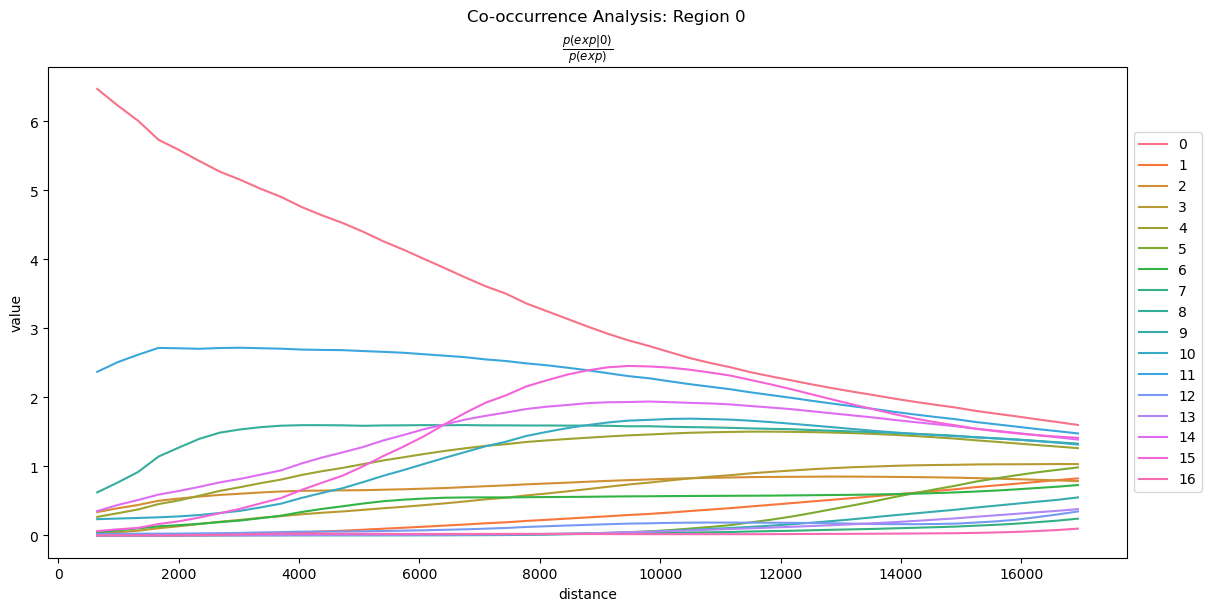

Analyzed co-occurrence for region 0 (697 spots)
Co-occurrence score = conditional probability of finding regions together at different distances


In [11]:
# Calculate co-occurrence across spatial dimensions
sq.gr.co_occurrence(sdata_visium.tables["table"], cluster_key="leiden_clusters")

# Visualize co-occurrence for the most abundant cluster
cluster_counts = sdata_visium.tables["table"].obs['leiden_clusters'].value_counts()
most_abundant_cluster = cluster_counts.index[0]

# Don't pass ax parameter - let squidpy handle the plotting
plt.figure(figsize=(12, 6))
sq.pl.co_occurrence(
    sdata_visium.tables["table"],
    cluster_key="leiden_clusters", 
    clusters=most_abundant_cluster,
    figsize=(12, 6)  # Use figsize parameter instead of ax
)
plt.suptitle(f'Co-occurrence Analysis: Region {most_abundant_cluster}')
plt.show()

print(f"Analyzed co-occurrence for region {most_abundant_cluster} ({cluster_counts[most_abundant_cluster]} spots)")
print("Co-occurrence score = conditional probability of finding regions together at different distances")

## Part 6: Ligand-Receptor Interaction Analysis

**Biological Question:** What molecular interactions might drive communication between neighboring tissue regions?

**Ligand-receptor analysis** identifies potential signaling molecules that could mediate cell-cell communication between spatially adjacent regions. This method:
- Uses curated databases of known ligand-receptor pairs
- Tests for enriched expression of complementary signaling molecules in neighboring regions
- Provides mechanistic hypotheses for spatial organization patterns

Note: This analysis requires comprehensive gene panels and may be limited in targeted datasets.

In [22]:
# Check if we have enough genes for ligand-receptor analysis
print(f"Available genes in dataset: {sdata_visium.tables['table'].n_vars}")
print(f"Unique clusters: {sdata_visium.tables['table'].obs['leiden_clusters'].unique()}")

# Workaround for numpy 2.0+ compatibility: numpy.NAN was removed, only numpy.nan exists
if not hasattr(np, 'NAN'):
    np.NAN = np.nan

try:
    # Perform ligand-receptor analysis between tissue regions
    sq.gr.ligrec(
        sdata_visium.tables["table"],
        n_perms=100,
        cluster_key="leiden_clusters",
        use_raw=False
    )
    
    print("Ligand-receptor analysis complete!")
    
    # Check available interaction data
    if 'leiden_clusters_ligrec' in sdata_visium.tables["table"].uns:
        lr_results = sdata_visium.tables["table"].uns['leiden_clusters_ligrec']
        print("Found ligand-receptor analysis results")
        
        # Display summary of results
        if hasattr(lr_results, 'shape'):
            print(f"Results shape: {lr_results.shape}")
        elif isinstance(lr_results, dict):
            print(f"Results contain {len(lr_results)} entries")
            
    else:
        print("No ligand-receptor results stored")
        
except Exception as e:
    print(f"Ligand-receptor analysis failed: {str(e)}")
    print("This is common with targeted gene panels that have limited ligand-receptor coverage")
    print("Skipping ligand-receptor visualization...")

Available genes in dataset: 17010
Unique clusters: ['0', '12', '6', '4', '10', ..., '3', '15', '14', '11', '16']
Length: 17
Categories (17, object): ['0', '1', '2', '3', ..., '13', '14', '15', '16']


/Users/tim.treis/Documents/GitHub/Spatial-Workshop/.pixi/envs/default/lib/python3.11/site-packages/anndata/__init__.py:70: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)


  0%|          | 0/100 [00:00<?, ?permutation/s]

/Users/tim.treis/Documents/GitHub/Spatial-Workshop/.pixi/envs/default/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/Users/tim.treis/Documents/GitHub/Spatial-Workshop/.pixi/envs/default/lib/python3.11/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
/Users/tim.treis/Documents/GitHub/Spatial-Workshop/.pixi/envs/default/lib/python3.11/site-packages/squidpy/gr/_utils.py:23: FutureWarning: `__version__` is d

Ligand-receptor analysis complete!
Found ligand-receptor analysis results
Results contain 3 entries


ValueError: After removing rows with only NaN interactions, none remain.

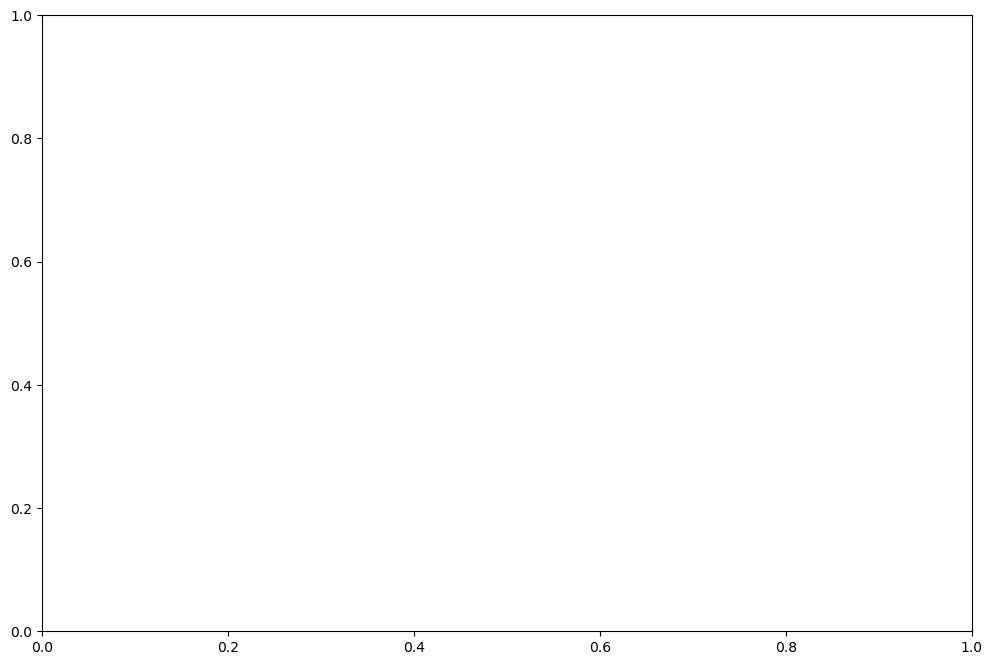

In [24]:
# Visualize ligand-receptor interactions (if available)
if 'leiden_clusters_ligrec' in sdata_visium.tables['table'].uns and len(sdata_visium.tables['table'].uns['leiden_clusters_ligrec']) > 0:
    # Select clusters with enough spots for meaningful analysis
    cluster_counts = sdata_visium.tables['table'].obs['leiden_clusters'].value_counts()
    major_clusters = cluster_counts.head(3).index.tolist()
    
    fig, ax = plt.subplots(figsize=(12, 8))
    sq.pl.ligrec(
        sdata_visium.tables['table'],
        cluster_key="leiden_clusters",
        source_groups=major_clusters[0],
        target_groups=major_clusters[1:3],
        means_range=(0.3, np.inf),  # Filter lowly expressed genes
        alpha=0.05,  # P-value threshold
        swap_axes=True,
        ax=ax
    )
    plt.title(f'Ligand-Receptor Interactions: {major_clusters[0]} → {major_clusters[1:3]}')
    plt.show()
    
    print(f"Ligand-receptor analysis between regions {major_clusters[0]} and {major_clusters[1:3]}")
else:
    print("Ligand-receptor visualization skipped - insufficient interaction data")
    print("This is common with targeted gene panels that don't include many ligand-receptor pairs")

## Part 7: Interactive Spatial Analysis (Instructor Demo)

**Note:** This section demonstrates interactive analysis using napari. For Docker users, this requires graphics setup, so follow along on the instructor's screen.

**Instructor will demonstrate:**
1. Loading spatial data in napari
2. Overlaying gene expression on tissue images
3. Interactive exploration of spatially variable genes
4. Manual annotation of regions of interest

In [ ]:
# Interactive napari demonstration (instructor will run this live)
# Uncomment for live interactive session:
import napari_spatialdata as nsd
viewer = nsd.Interactive(sdata_visium)
# print("Napari viewer launched - follow along on instructor's screen")

## Part 8: Workshop Summary and Key Takeaways

### 🔬 Spatial Statistics Methods Learned:
- **Spatial Neighbors Graph**: Foundation for all spatial analyses
- **Moran's I**: Identifies genes with spatial expression patterns 
- **Neighborhood Enrichment**: Reveals tissue region adjacency preferences
- **Co-occurrence Analysis**: Quantifies spatial associations across distances
- **Ligand-Receptor Analysis**: Identifies potential cell communication mechanisms

### 🧬 Biological Insights:
- Spatial gene expression patterns reveal tissue architecture
- Tissue regions show non-random spatial organization
- Quantitative spatial analysis complements visual inspection
- Molecular mechanisms can be inferred from spatial patterns

### 🚀 Next Steps for Your Research:
- Apply these methods to your own spatial datasets
- Compare spatial organization between conditions (healthy vs. disease)
- Validate predicted ligand-receptor interactions with functional studies
- Integrate with single-cell RNA-seq for deeper cellular insights
- Explore advanced methods like spatial domain detection

In [15]:
# Calculate summary statistics
n_spatially_variable = (moran_results['pval_sim'] < 0.05).sum()
top_gene = moran_results.index[0]
top_moran = moran_results.iloc[0]['I']

print("📊 ANALYSIS SUMMARY:")
print(f"• Dataset: {sdata_visium.tables['table'].n_obs} tissue spots, {sdata_visium.tables['table'].n_vars} genes")
print(f"• Tissue regions identified: {n_clusters}")
print(f"• Spatial neighbors per spot: {sdata_visium.tables['table'].obsp['spatial_connectivities'].nnz / sdata_visium.tables['table'].n_obs:.1f}")
print(f"• Spatially variable genes (p<0.05): {n_spatially_variable} out of {len(hvg_genes)} tested")
print(f"• Most spatially coherent gene: {top_gene} (Moran's I = {top_moran:.3f})")

📊 ANALYSIS SUMMARY:
• Dataset: 5734 tissue spots, 17010 genes
• Tissue regions identified: 17
• Spatial neighbors per spot: 5.8
• Spatially variable genes (p<0.05): 3058 out of 3762 tested
• Most spatially coherent gene: HBB (Moran's I = 0.814)


### 📚 Resources:
- [Squidpy documentation](https://squidpy.readthedocs.io/)
- [SpatialData ecosystem](https://spatialdata.scverse.org/)
- [scverse community](https://discourse.scverse.org/)